# シンプルなRNNの実装
シンプルな再帰型ニューラルネットワーク（RNN）を用いて、時系列データを学習します。

## 訓練用データの作成
RNNに用いる訓練用のデータを作成します。  
サイン関数に乱数でノイズを加えたデータを作成し、過去の時系列データから未来の値を予測できるようにします。

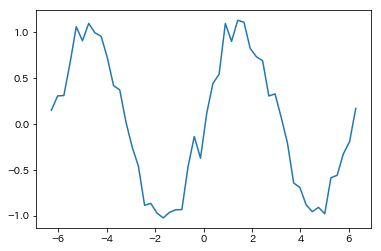

(40, 10, 1)
(40, 10, 1)


In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

nrange = 2    # デフォルトは 2
x_data = np.linspace(-nrange*np.pi, nrange*np.pi, nrange*25)  # -2πから2πまで
sin_data = np.sin(x_data)  + 0.1*np.random.randn(len(x_data))  # sin関数に乱数でノイズを加える

plt.plot(x_data, sin_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(x_data)-n_rnn  # サンプル数。50 - 10 = 40 サンプル
x = np.zeros((n_sample, n_rnn))  # 入力。 40 × 10
t = np.zeros((n_sample, n_rnn))  # 正解
for i in range(0, n_sample):
    x[i] = sin_data[i:i+n_rnn]
    t[i] = sin_data[i+1:i+n_rnn+1]  # 時系列を入力よりも一つ後にずらす

x = x.reshape(n_sample, n_rnn, 1)  # KerasにおけるRNNでは、入力を（サンプル数、時系列の数、入力層のニューロン数）にする
print(x.shape)
t = t.reshape(n_sample, n_rnn, 1)  # 今回は入力と同じ形状
print(t.shape)

## RNNの構築
Kerasを使ってRNNを構築します。  
今回は、Kerasが持つRNNの中で一番シンプルなSimpleRNN層を使います。

In [13]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

model = Sequential()
# SimpleRNN層の追加。return_sequenceをTrueにすると、時系列の全てのRNN層が出力を返す。
# return_sequenceをTrueをFalseにすると、最後のRNN層のみが出力を返す。
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, n_in), return_sequences=True))   # return_sequence のデフォルトは False。tanhがデフォルト
model.add(Dense(n_out, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="sgd")  # 誤差は二乗誤差、最適化アルゴリズムはSGD
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 10, 20)            440       
_________________________________________________________________
dense_3 (Dense)              (None, 10, 1)             21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
None


## 学習
構築したRNNのモデルを使って、学習を行います。  

In [14]:
history = model.fit(x, t, epochs=20, batch_size=batch_size, validation_split=0.1)

Train on 36 samples, validate on 4 samples
Epoch 1/20
36/36 [==============================] - 1s 28ms/step - loss: 1.0434 - val_loss: 0.5476
Epoch 2/20
36/36 [==============================] - 0s 1ms/step - loss: 0.5517 - val_loss: 0.3322
Epoch 3/20
36/36 [==============================] - 0s 1ms/step - loss: 0.3517 - val_loss: 0.2380
Epoch 4/20
36/36 [==============================] - 0s 1ms/step - loss: 0.2650 - val_loss: 0.1932
Epoch 5/20
36/36 [==============================] - 0s 1ms/step - loss: 0.2190 - val_loss: 0.1557
Epoch 6/20
36/36 [==============================] - 0s 1ms/step - loss: 0.1927 - val_loss: 0.1349
Epoch 7/20
36/36 [==============================] - 0s 1ms/step - loss: 0.1741 - val_loss: 0.1225
Epoch 8/20
36/36 [==============================] - 0s 1ms/step - loss: 0.1613 - val_loss: 0.1190
Epoch 9/20
36/36 [==============================] - 0s 1ms/step - loss: 0.1493 - val_loss: 0.1074
Epoch 10/20
36/36 [==============================] - 0s 1ms/step - loss: 0

## 学習の推移
誤差の推移を確認します。

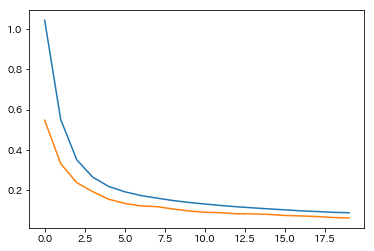

In [15]:
loss = history.history['loss']
vloss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(vloss)), vloss)
plt.show()

## 学習済みモデルの使用
RNNの学習済みモデルを使って、サイン関数の次の値を予測します。

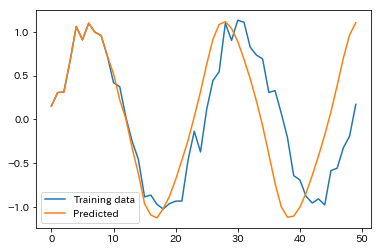

In [16]:
predicted = x[0].reshape(-1)  # 最初の入力。reshape(-1)で一次元のベクトルにする。

for i in range(0, n_sample):
    y = model.predict(predicted[-n_rnn:].reshape(1, n_rnn, 1))  # 直近のデータを使って予測を行う
    predicted = np.append(predicted, y[0][n_rnn-1][0])  # 出力の最後の結果をpredictedに追加する

plt.plot(np.arange(len(sin_data)), sin_data, label="Training data")
plt.plot(np.arange(len(predicted)), predicted, label="Predicted")
plt.legend()
plt.show()

直近の時系列データを使って、次の値を予測できるようになりました。  
今回はサインカーブの予測を行いましたが、同様の技術を株価の予測などに応用することも可能です。

## 課題
最初のセルのx_dataの範囲をさらに広げて、RNNで学習できるかどうか試してみましょう。